In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.metrics import  classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline 

In [7]:
import importlib
import ids_common
importlib.reload(ids_common)

<module 'ids_common' from 'd:\\stuff\\univ\\ids\\ids_common.py'>

In [8]:
df = pd.read_csv('./dataset/Edge-IIoTset-dataset/Selected dataset for ML and DL/DNN-EdgeIIoT-dataset.csv', low_memory=False)
ids_common.prepare_dataset_v1(df, verbose=True)
df.info()

Before: dropna: NA: 0, DUPS: 309530
After: dropna: NA: 0, DUPS: 0
<class 'pandas.core.frame.DataFrame'>
Index: 1909671 entries, 0 to 2219193
Data columns (total 89 columns):
 #   Column                                                                                                Dtype   
---  ------                                                                                                -----   
 0   arp.opcode                                                                                            float64 
 1   arp.hw.size                                                                                           float64 
 2   icmp.checksum                                                                                         float64 
 3   icmp.seq_le                                                                                           float64 
 4   icmp.unused                                                                                           float64 
 5   http.cont

In [9]:
SEED = random.randint(0, 42424242)
SEED = 42
print(f'SEED = {SEED}')

#TODO: rename to detection_class and classification_class
target_label_2_class = 'Attack_label' # 0 indicates normal and 1 indicates attacks
target_label_15_class = 'Attack_type'

def ds_detection_split(dataset):
    """"Normal vs Attack"""
    y = dataset[target_label_2_class]
    X = dataset.drop([target_label_2_class, target_label_15_class], axis=1, inplace=False)
    return train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

def ds_split(dataset):
    """Simple split, stratify against Attack_type"""
    return train_test_split(dataset, test_size=0.2, random_state=SEED, stratify=dataset[target_label_15_class])

def ds_classification_split(dataset):
    """Split on Attack_type"""
    loc_df = dataset.drop(dataset[dataset[target_label_2_class] == 0].index, inplace=False)
    y = loc_df[target_label_15_class]
    X = loc_df.drop([target_label_2_class, target_label_15_class], axis=1, inplace=False)
    return train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

SEED = 42


In [10]:
df_train_global, df_test_global = ds_split(df)
print(f'df_train_global={df_train_global.shape}')
print(f'df_test_global={df_test_global.shape}')

df_train_global=(1527736, 89)
df_test_global=(381935, 89)


In [11]:
X_train_detection, X_test_detection, y_train_detection, y_test_detection = ds_detection_split(df_train_global)
print(f'X_train_detection={X_train_detection.shape} y_train_detection={y_train_detection.shape}')
print(f'X_test_detection={X_test_detection.shape}   y_test_detection={y_test_detection.shape}')

X_train_detection=(1222188, 87) y_train_detection=(1222188,)
X_test_detection=(305548, 87)   y_test_detection=(305548,)


In [12]:
X_train_classification, X_test_classification, y_train_classification, y_test_classification = ds_classification_split(df_train_global)
print(f'X_train_classification={X_train_classification.shape} y_train_classification={y_train_classification.shape}')
print(f'X_test_classification={X_test_classification.shape}   y_test_classification={y_test_classification.shape}')

X_train_classification=(349230, 87) y_train_classification=(349230,)
X_test_classification=(87308, 87)   y_test_classification=(87308,)


In [13]:
def report(y_train, y_train_predict, y_test, y_test_predict):

    print('TRAIN:')
    print(classification_report(y_train, y_train_predict))

    print('TEST:')
    print(classification_report(y_test, y_test_predict))

def plot_cm(y_true, y_predict):
    title='Normalized confusion matrix'

    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_predict,
        # display_labels=Attack_type_classes,
        cmap=plt.cm.Blues,
        normalize='true',
        values_format='.2f'
    )
    disp.ax_.set_title(title)
    disp.figure_.set_size_inches(8, 8, forward=True)
    plt.xticks(rotation=90)
    plt.show()

TRAIN:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    872958
           1       1.00      0.98      0.99    349230

    accuracy                           0.99   1222188
   macro avg       0.99      0.99      0.99   1222188
weighted avg       0.99      0.99      0.99   1222188

TEST:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97    218240
           1       0.92      0.91      0.92     87308

    accuracy                           0.95    305548
   macro avg       0.94      0.94      0.94    305548
weighted avg       0.95      0.95      0.95    305548



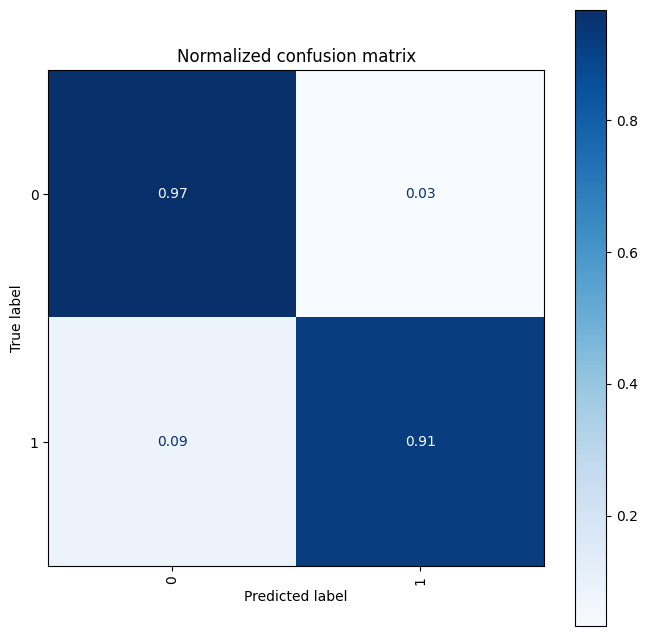

In [14]:
detector = DecisionTreeClassifier(random_state=SEED)

detector.fit(X_train_detection, y_train_detection)
y_train_detection_predict = detector.predict(X_train_detection)
y_test_detection_predict = detector.predict(X_test_detection)

report(y_train_detection, 
       y_train_detection_predict, 
       y_test_detection,
       y_test_detection_predict)

plot_cm(y_test_detection, y_test_detection_predict)


TRAIN:
                       precision    recall  f1-score   support

             Backdoor       0.99      1.00      1.00     15377
            DDoS_HTTP       0.96      1.00      0.98     31068
            DDoS_ICMP       1.00      1.00      1.00     43481
             DDoS_TCP       1.00      1.00      1.00     32040
             DDoS_UDP       1.00      1.00      1.00     77802
       Fingerprinting       0.97      0.98      0.98       545
                 MITM       1.00      1.00      1.00       229
             Password       0.99      0.99      0.99     31957
        Port_Scanning       1.00      1.00      1.00     12785
           Ransomware       0.99      0.99      0.99      6201
        SQL_injection       0.99      0.99      0.99     32529
            Uploading       1.00      0.96      0.98     23557
Vulnerability_scanner       1.00      1.00      1.00     32017
                  XSS       1.00      0.98      0.99      9642

             accuracy                         

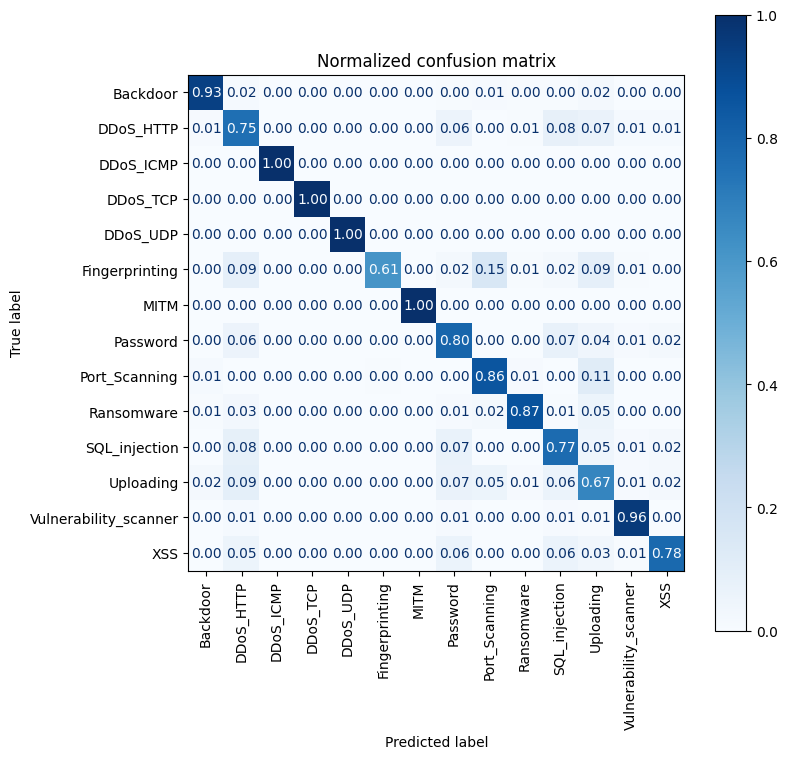

In [15]:
classifier = DecisionTreeClassifier(random_state=SEED)

classifier.fit(X_train_classification, y_train_classification)
y_train_classification_predict = classifier.predict(X_train_classification)
y_test_classification_predict = classifier.predict(X_test_classification)

report(y_train_classification, 
       y_train_classification_predict, 
       y_test_classification,
       y_test_classification_predict)

plot_cm(y_test_classification, y_test_classification_predict)

DETECTION:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97    272800
           1       0.91      0.91      0.91    109135

    accuracy                           0.95    381935
   macro avg       0.94      0.94      0.94    381935
weighted avg       0.95      0.95      0.95    381935



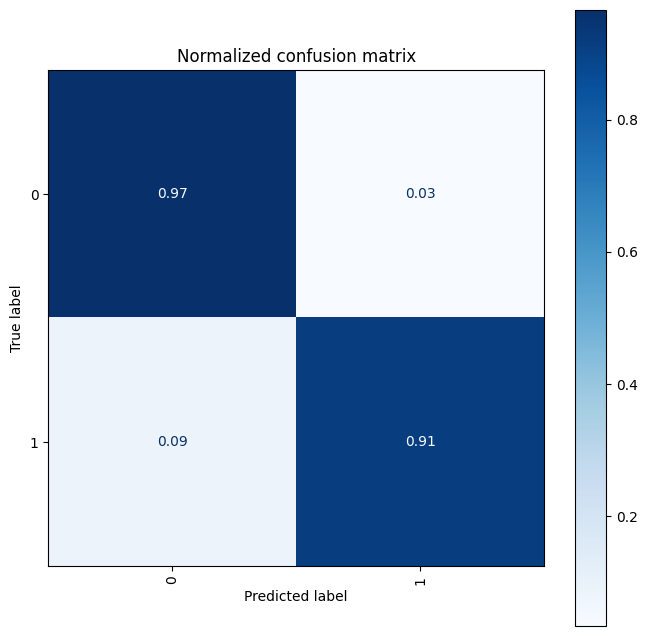

CLASSIFICATION:
                       precision    recall  f1-score   support

             Backdoor       0.93      0.93      0.93      4805
            DDoS_HTTP       0.67      0.68      0.67      9709
            DDoS_ICMP       1.00      1.00      1.00     13588
             DDoS_TCP       1.00      1.00      1.00     10012
             DDoS_UDP       1.00      1.00      1.00     24314
       Fingerprinting       0.71      0.67      0.69       171
                 MITM       1.00      1.00      1.00        72
               Normal       0.97      0.97      0.97    272800
             Password       0.74      0.74      0.74      9987
        Port_Scanning       0.86      0.86      0.86      3995
           Ransomware       0.89      0.88      0.88      1938
        SQL_injection       0.72      0.72      0.72     10165
            Uploading       0.65      0.63      0.64      7361
Vulnerability_scanner       0.96      0.96      0.96     10005
                  XSS       0.76      

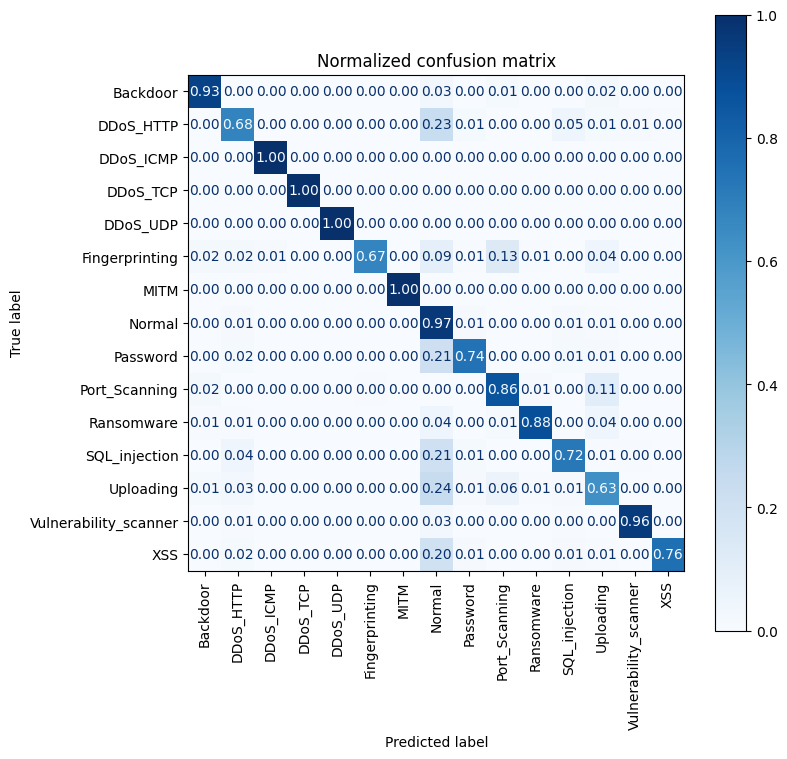

In [16]:
# combined detection with classification
y_global_label = df_test_global[target_label_2_class]
y_global_type = df_test_global[target_label_15_class]
X_global = df_test_global.drop([target_label_2_class, target_label_15_class], axis=1, inplace=False)


y_global_detection_predict = detector.predict(X_global)

ds_classification = df_test_global[y_global_detection_predict==1]
X_global_classification = ds_classification.drop([target_label_2_class, target_label_15_class], axis=1, inplace=False)

y_global_classification_predict = classifier.predict(X_global_classification)


global_result = pd.Series(y_global_detection_predict, index=X_global.index.copy())
global_result = global_result.map(lambda x: 'Normal' if x==0 else 'Attack')
global_result.loc[X_global_classification.index] = y_global_classification_predict

print('DETECTION:')
print(classification_report(y_global_label, y_global_detection_predict))
plot_cm(y_global_label, y_global_detection_predict)

print('CLASSIFICATION:')
print(classification_report(y_global_type, global_result))
plot_cm(y_global_type, global_result)



# XAI

In [17]:

sorted(zip(detector.feature_importances_.round(2),
           detector.feature_names_in_),
           reverse=True)[:10]

[(0.33, 'tcp.flags'),
 (0.31, 'tcp.seq'),
 (0.15, 'tcp.ack'),
 (0.09, 'tcp.checksum'),
 (0.08, 'tcp.len'),
 (0.03, 'tcp.ack_raw'),
 (0.01, 'udp.time_delta'),
 (0.01, 'mqtt.conflags'),
 (0.0, 'udp.stream'),
 (0.0, 'tcp.flags.ack')]

In [18]:
sorted(zip(classifier.feature_importances_.round(2),
           classifier.feature_names_in_),
           reverse=True)[:10]

[(0.25, 'tcp.ack'),
 (0.22, 'udp.stream'),
 (0.13, 'icmp.seq_le'),
 (0.09, 'tcp.seq'),
 (0.08, 'tcp.checksum'),
 (0.07, 'http.content_length'),
 (0.06, 'tcp.len'),
 (0.06, 'tcp.ack_raw'),
 (0.03, 'tcp.connection.rst'),
 (0.0, 'udp.time_delta')]

In [19]:
detector.get_n_leaves()

50667

In [20]:
# tree.plot_tree(detector, max_depth=4)

# drafts

In [21]:
# hard stop
raise AssertionError('drafts: stop execution')

AssertionError: drafts: stop execution

In [ ]:
# first try

# df_train_global, df_test_global = ds_split(df)

y_global_detection = df_test_global[target_label_2_class]
X_global_detection = df_test_global.drop([target_label_2_class, target_label_15_class], axis=1, inplace=False)

y_global_detection_predict = detector.predict(X_global_detection)
print('DETECTION:')
print(classification_report(y_global_detection, y_global_detection_predict))
plot_cm(y_global_detection, y_global_detection_predict)

# np.unique(y_global_detection_predict, return_counts=True)
# (array([0, 1], dtype=int64), array([272875, 109060], dtype=int64))

ds_classification = df_test_global[y_global_detection_predict==1]

y_global_classification = ds_classification[target_label_15_class]
X_global_classification = ds_classification.drop([target_label_2_class, target_label_15_class], axis=1, inplace=False)

y_global_classification_predict = classifier.predict(X_global_classification)

print('CLASSIFICATION:')
print(classification_report(y_global_classification, y_global_classification_predict))
plot_cm(y_global_classification, y_global_classification_predict)

# pd.Series([True, False, True, True, False, False, False, True]).values

In [ ]:
detected_attack_type = []

y_global_label = df_test_global[target_label_2_class]
y_global_type = df_test_global[target_label_15_class]
X_global = df_test_global.drop([target_label_2_class, target_label_15_class], axis=1, inplace=False)

c = 0
for i in df_test_global.index:
    
   
    xx = X_global.loc[i].to_numpy().reshape(1, -1)
    y_detected = detector.predict(xx)[0]

    traffic_type = None
     
    if not y_detected:
        traffic_type = 'Normal'
    else:
        y_class_predicted = classifier.predict(xx)[0]
        traffic_type = y_class_predicted


    detected_attack_type.append(traffic_type)
    

    # print(traffic_type, y_global_label.loc[i], y_global_type.loc[i])
    
    # c += 1
    # if c > 10:
    #     break

print('ALL:')
print(classification_report(y_global_type, detected_attack_type))
plot_cm(y_global_type, detected_attack_type)

array([0, 0, 1, 0, 1, 0, 0, 0, 0, 1], dtype=int64)